# Retrieve Data

Grabbing WebIDs ...
WebID collection complete!
14:49:39: Sending API request... Chunk 1 of 1
14:49:40: Response recieved for 1 tags! (1.54)


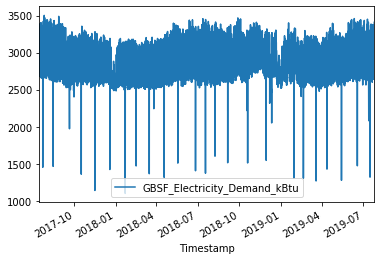

In [92]:
import sys
"""Put the path to the eco-tools folder in the following line... should look something like this one below"""
sys.path.append(r"C:\\Users\\ejgoldbe\\Desktop\\eco-tools/") #path to PI CLient
#if not working: pip install requests-kerberos Desktop
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from ecotools.pi_client import pi_client
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from dateutil.relativedelta import relativedelta
from matplotlib.lines import Line2D
import pickle
pc = pi_client(root='readonly')
points = pc.search_by_point("GBSF_Electricity_Demand_kBtu")
second_points = pc.search_by_point('aitit4045*')
start = "07-17-2017"
end = "*"
interval = '1h' #can be 1d 2d for days or 1s for seconds or 1m for minutes
calculation = 'summary'
df = pc.get_stream_by_point(points, start = start, 
                            end = end, calculation=calculation,
                            interval=interval)
df = df.dropna()
df.plot()




#algo that takes any data, adds new variable, splits xpercent training xpercent testing, predicts on X_TEST
#takes predictions, actual y_test, gets residuals - Absolute value
#determine threshold using SD
#identify outliers in y_test using that
#use that threshold to identify outliers in the whole dataset



# Add New Variables

                     GBSF_Electricity_Demand_kBtu  rolling_ten  \
Timestamp                                                        
2017-07-17 00:00:00                   2718.246116  2718.246116   
2017-07-17 01:00:00                   2706.419560  2712.332838   
2017-07-17 02:00:00                   2714.511580  2713.059085   

                     rolling_twenty  rolling_thirty  
Timestamp                                            
2017-07-17 00:00:00     2718.246116     2718.246116  
2017-07-17 01:00:00     2712.332838     2712.332838  
2017-07-17 02:00:00     2713.059085     2713.059085  


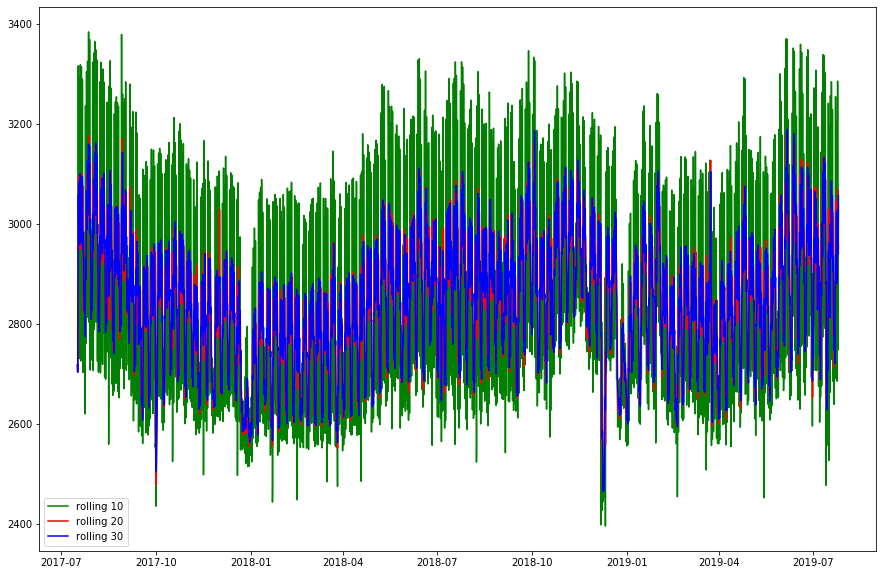

In [93]:
#add a rolling 10 and a rolling 20 mean, as well as a rolling 30
#these look at the past 10, 20, or 30 values (including the current point) and use the mean of those numbers
from functools import reduce


rolling_ten = df.rolling(window=10, min_periods=1).mean()
rolling_twenty = df.rolling(window=20, min_periods=1).mean()
rolling_thirty = df.rolling(window=30, min_periods=1).mean()

#merge new variables
df['rolling_ten'] = rolling_ten.values
df['rolling_twenty'] = rolling_twenty.values
df['rolling_thirty'] = rolling_thirty.values

print(df.head(3))

plt.figure(figsize = (15, 10))
plt.plot(rolling_ten.index, rolling_ten.values, color = 'green', label = 'rolling 10')
plt.plot(rolling_twenty.index, rolling_twenty.values, color = 'red', label = 'rolling 20')
plt.plot(rolling_thirty.index, rolling_thirty.values, color = 'blue', label = 'rolling 30')
plt.legend(loc = 'best')
plt.show()



# Split Into Training + Testing

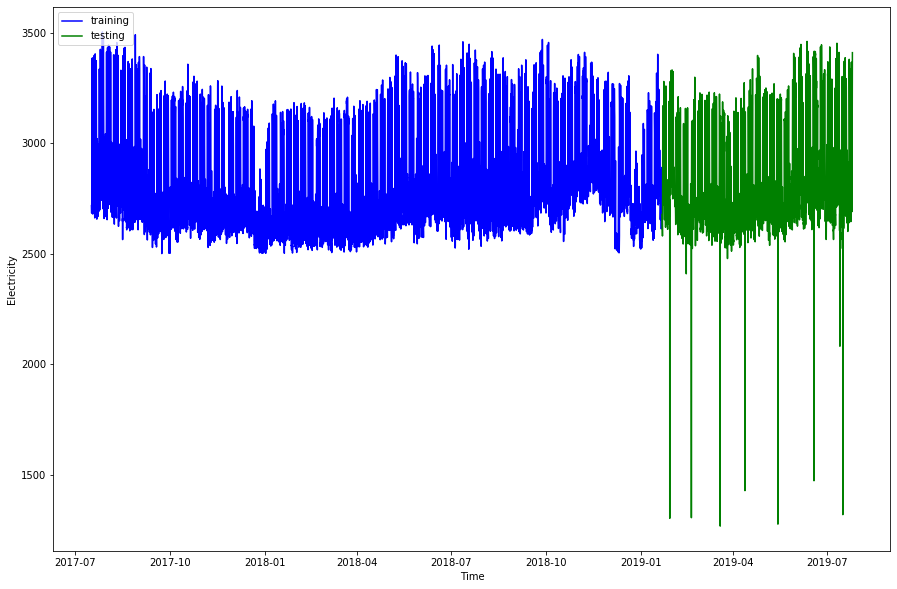

In [94]:
from sklearn.model_selection import train_test_split


X = df.iloc[:, [1, 2, 3]]
y = df.iloc[:, [0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)
#plot the electricity data that was put into training - y_train, y_test
y_train = y_train[y_train.values > 2500]
new_training_indexes = y_train.index.tolist()
X_train = X_train.ix[new_training_indexes]
plt.figure(figsize = (15, 10))
plt.plot(y_train.index, y_train.values, color = 'blue', label = 'training')
plt.plot(y_test.index, y_test.values, color = 'green', label = 'testing')
plt.xlabel("Time")
plt.ylabel("Electricity")
plt.legend(loc = 'upper left')
plt.show()


# Fit Models and Compare Accuracy

In [63]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}
gb = GradientBoostingRegressor()
grid_search = GridSearchCV(gb, param_grid, cv = 2)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
#refit model with best parameters
new_gb = GradientBoostingRegressor(**grid_search.best_params_)
new_gb.fit(X_train, y_train)
print("Gradient Boosting Regressor accuracy:", new_gb.score(X_test, y_test))
#compare to rf
#fit with the same best params
rf = RandomForestRegressor(**grid_search.best_params_)
rf.fit(X_train, y_train)
print("Random Forest Regressor Accuracy:", rf.score(X_test, y_test))

{'n_estimators': 200}
Gradient Boosting Regressor accuracy: 0.6802997274868967
Random Forest Regressor Accuracy: 0.713208309777797


# Evaluate Predicted Versus Actual For Best Model

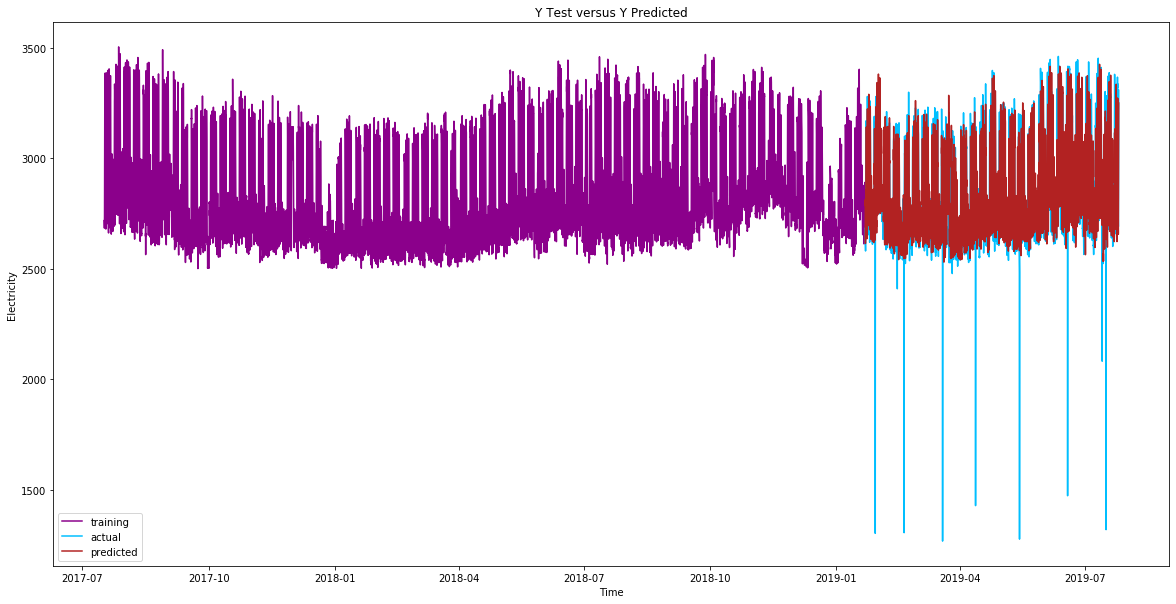

In [6]:
y_preds = rf.predict(X_test)
actual_series = y_test
pred_series = pd.Series(y_preds, index = y_test.index)
y_train_series = y_train
plt.figure(figsize = (20, 10))
plt.plot(y_train_series.index, y_train_series.values, color = 'darkmagenta', label = 'training')
plt.plot(actual_series.index, actual_series.values, color = 'deepskyblue', label = 'actual')
plt.plot(pred_series.index, pred_series.values, color = 'firebrick', label = 'predicted')
plt.xlabel("Time")
plt.ylabel("Electricity")
plt.title("Y Test versus Y Predicted")
plt.legend(loc = 'best')
plt.show()


# Extract Residuals From Actual Vs. Predicted

,Actual,Modeled,Difference
Timestamp,,,
2019-01-21 20:00:00,2683.137136,2788.198330,3.915610
2019-01-21 21:00:00,2677.970907,2812.669176,5.029863
2019-01-21 22:00:00,2662.374329,2795.640533,5.005540
2019-01-21 23:00:00,2621.139537,2777.559351,5.967626
2019-01-22 00:00:00,2638.872721,2686.651250,1.810566


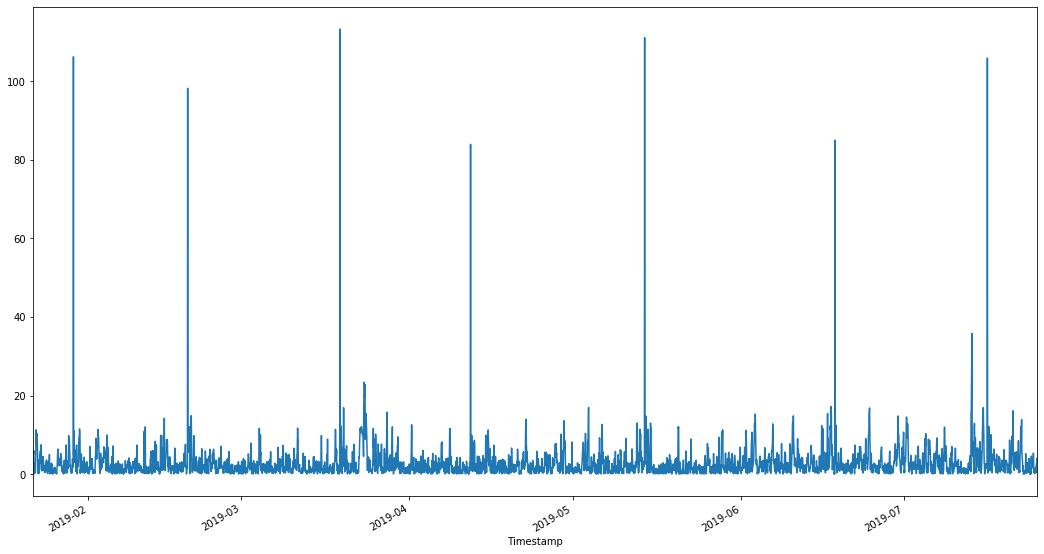

In [67]:
df = pd.concat([actual_series, pred_series], axis=1)
df.columns = ['Actual', 'Modeled']
df.eval('Difference = (Actual - Modeled)/ Actual * 100', inplace=True)
df["Difference"] = df['Difference'].abs()
df.head(3)
df.Difference.plot(figsize = (18, 10))

from IPython.display import display, HTML
display(df.head())

#subset df with mask, loc so only outliers
#from there can get index of outliers


# Determine Threshold For Residual Outlier

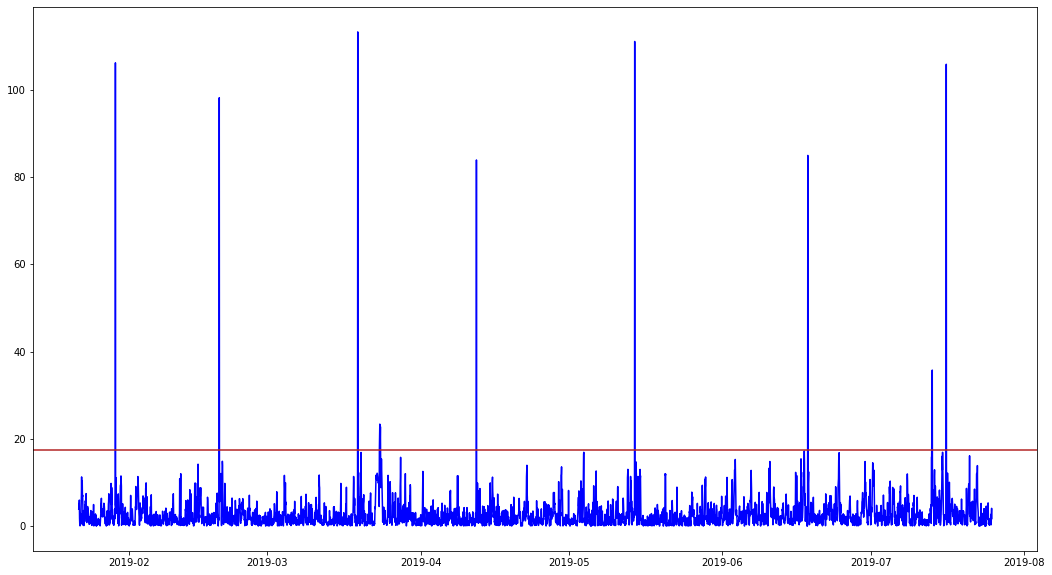

In [68]:
#extract threshold using standard deviation
bound = np.mean(resids) + 3*np.std(resids)
plt.figure(figsize = (18, 10))
plt.plot(df.index, df.Difference, color = 'blue')
plt.axhline(y = bound, color = 'firebrick')


# Extract Original Outliers in YTest From Residual Outliers


Text(0.5, 1.0, 'YTest')

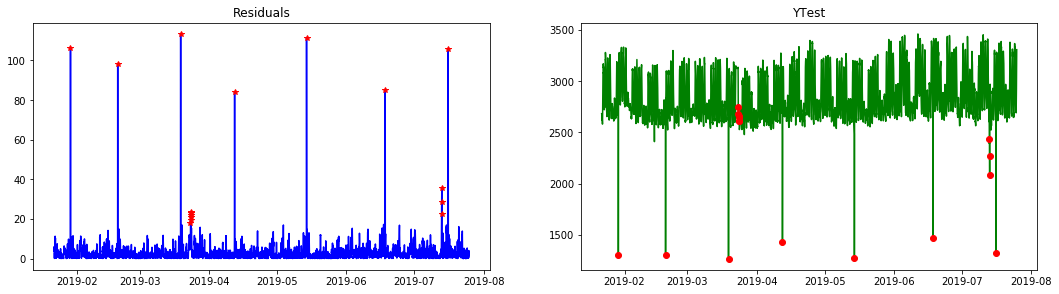

In [73]:
outlier_df = df.loc[df.Difference > bound]
outlier_residuals = outlier_df['Difference'].tolist()
#first plot residual outliers
plt.figure(figsize = (18, 10))
plt.subplot(2, 2, 1)
plt.plot(df.index, df.Difference, color = 'blue')
sizes = [20 for i in range(outlier_df.shape[0])]
index_outliers = []
for outlier in outlier_residuals:
    index_outlier = df.Difference.values.tolist().index(outlier)
    index_outliers.append(index_outlier)
    date_index = df.index[index_outlier]
    plt.plot(date_index, outlier, color = 'red', marker ='*')
plt.title("Residuals")    
    
#use residual outliers to plot outliers in y_test
plt.subplot(2, 2, 2)
plt.plot(df.index, df.Actual, color = 'green')
for index in index_outliers:
    actual_outlier = df.Actual[index]
    date_outlier = df.index[index]
    plt.plot(date_outlier, actual_outlier, color = 'red', marker = 'o')
plt.title("YTest")

# Save Random Forest Model With All Data



In [104]:
import pickle
#retrieve X, y - the data for the last few years
new_df = pd.merge(X, y, on = 'Timestamp')
new_df = new_df.loc[new_df.GBSF_Electricity_Demand_kBtu > 2500]
new_X = new_df.iloc[:, [0, 1, 2]]
new_y = new_df.iloc[:, [3]]
#refit the random forest model
rf = RandomForestRegressor(**grid_search.best_params_)
rf.fit(new_X, new_y)
filename = 'finalized_rf.sav'
#save the model
pickle.dump(rf, open(filename, 'wb'))



